In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import talib as ta

In [110]:
activo = 'ETH-USD'
df = yf.Ticker(activo)
df = df.history(start='2018-01-01', end='2024-10-01')

In [111]:
# # Calcular medias móviles
# df['SMA_100'] = df['Close'].rolling(window=100).mean()
# df['SMA_200'] = df['Close'].rolling(window=200).mean()

In [112]:
# Calculo del MACD
df['MACD'], df['Signal_line'], df['Histogram'] = ta.MACD(df['Close'], fastperiod=12, 
                                                        slowperiod=26, signalperiod=9)

In [113]:
df['Signal'] = 0
df.loc[(df['MACD'] > df['Signal']) & (df['Histogram'] > 0), 'Signal'] = 1

df.loc[(df['MACD'] < df['Signal']) & (df['Histogram'] < 0), 'Signal'] = -1

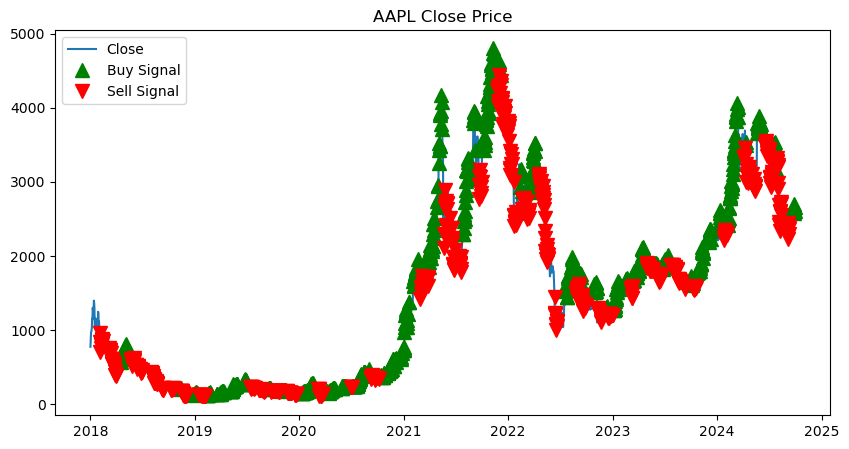

In [114]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close')
plt.plot(df.loc[df['Signal'] == 1, 'Close'], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(df.loc[df['Signal'] == -1, 'Close'], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('AAPL Close Price')
plt.legend()
plt.show()


In [115]:
#Simular la ejecución de las ordenes
df['Position'] = df['Signal'].shift()

In [116]:
# Definir comisiones y slippage
commission = 0.001  # 0.1% por operación
slippage = 0.0005  # 0.05% de slippage en cada operación

In [117]:
# Calcular los retornos de la estrategia con comisiones y slippage
df['Returns'] = df['Close'].pct_change()
df['Strategy_Returns'] = df['Position'] * df['Returns']

In [118]:
# Aplicar comisiones y slippage
df['Strategy_Returns'] -=(abs(df['Position'].diff()) * (commission + slippage))
df.tail(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal_line,Histogram,Signal,Position,Returns,Strategy_Returns
Date,,,,,,,,,,,,,,
2024-09-28 00:00:00+00:00,2695.815918,2704.928711,2652.250488,2677.539062,10252590559,0.0,0.0,45.793914,10.395345,35.398569,1,1.0,-0.006811,-0.006811
2024-09-29 00:00:00+00:00,2677.628662,2683.445801,2635.584961,2659.346924,11126215671,0.0,0.0,48.452507,18.006777,30.445729,1,1.0,-0.006794,-0.006794
2024-09-30 00:00:00+00:00,2659.292725,2662.489014,2576.976074,2603.062744,17826446789,0.0,0.0,45.493378,23.504097,21.989281,1,1.0,-0.021165,-0.021165


In [119]:
# Eliminar NaNs
df.dropna(inplace=True)

In [122]:
# Calcular rendimiento total y anualizado
total_return = (df['Strategy_Returns'] + 1).prod() - 1
annualized_return = (1 + total_return) ** (252 / len(df) - 1) # Ajustando por 252 dias de trading

print(f'Rendimiento Total: {total_return:.2%}')
print(f'Rendimiento Anualizado: {annualized_return:.2%}')

Rendimiento Total: 673.13%
Rendimiento Anualizado: 15.99%


In [123]:
# Ratio de Sharpe
risk_free_rate = 0.045
excess_return = df['Strategy_Returns'].mean() - (risk_free_rate / 252)
sharpe_ratio = excess_return / df['Strategy_Returns'].std()
print(f'Ratio de Sharpe: {sharpe_ratio:.2f}')

Ratio de Sharpe: 0.04
